# Setup


In [105]:
import importlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import shap
from IPython.display import display
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC

import ml_utils

importlib.reload(ml_utils)

<module 'ml_utils' from '/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/notebooks/ml_utils.py'>

In [2]:
# константы
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

# тема графиков
pio.templates.default = "plotly_dark"  # plotly_dark seaborn
pio.renderers.default = "png"  # png notebook_connected plotly_mimetype

# Load data

In [64]:
def load_train() -> pd.DataFrame:
    """Load train data."""
    df = pd.read_csv('../data/train.csv')
    types = {
        bool: [
            'active',
            'alco',
            'cardio',
            'smoke',
        ],
        np.int8: [
            'cholesterol',
            'gender',
            'gluc',
        ]
    }
    for t, columns in types.items():
        for col in columns:
            df[col] = df[col].astype(t)
    df = shuffle(df, random_state=1)
    return df


def load_test() -> pd.DataFrame:
    """Load test data."""
    return pd.read_csv('../data/test.csv')

In [65]:
df = load_train()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 6670 to 5192
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int8   
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int8   
 8   gluc         70000 non-null  int8   
 9   smoke        70000 non-null  bool   
 10  alco         70000 non-null  bool   
 11  active       70000 non-null  bool   
 12  cardio       70000 non-null  bool   
dtypes: bool(4), float64(1), int64(5), int8(3)
memory usage: 4.2 MB


In [6]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0


# EDA

In [7]:
df_eda = load_train()

## Target

In [69]:
print('Кол-во заболевших пациентов')
print(df_eda['cardio'].value_counts())

Кол-во заболевших пациентов
False    35021
True     34979
Name: cardio, dtype: int64


Кол-во значений "0" и "1" практически одинаково. Значит, с небалансом классов бороться не нужно.

## Features

### cardio (target)

In [8]:
print('Кол-во заболевших пациентов')
print(df_eda['cardio'].value_counts())

Кол-во заболевших пациентов
False    35021
True     34979
Name: cardio, dtype: int64


### active

In [9]:
print('Кол-во пациентов по признаку active')
print(df_eda['active'].value_counts())

Кол-во пациентов по признаку active
True     56261
False    13739
Name: active, dtype: int64


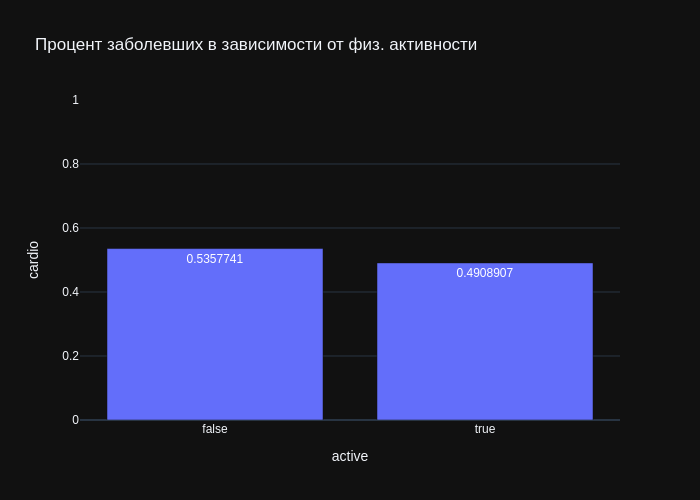

In [10]:
cardio_by_active = df_eda.pivot_table(index='active', values='cardio')

px.bar(
    cardio_by_active,
    x=cardio_by_active.index,
    y='cardio',
    title='Процент заболевших в зависимости от физ. активности',
    text_auto=True,
    range_y=(0, 1),
)

Физ. активность немного снижает риск болезни, хотя зависимость не сильная.

### age

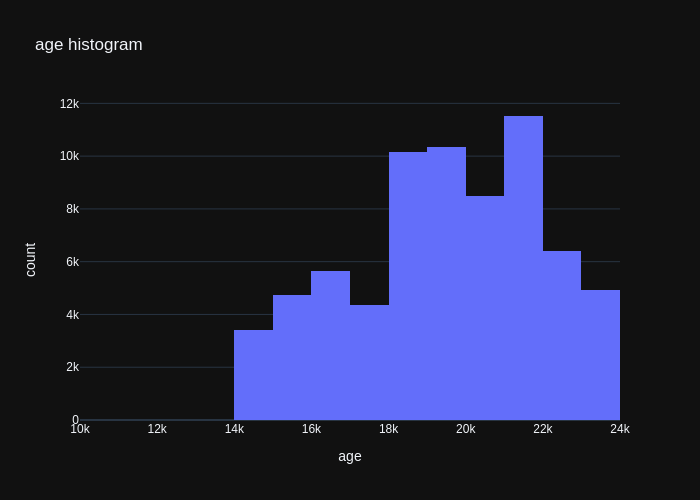

In [11]:
px.histogram(df_eda, x='age', nbins=25, title='age histogram')

Возраст, скорее всего, приводится в днях

In [12]:
print('Исходные данные:')
print(f'min = {df_eda["age"].min()}; max = {df_eda["age"].max()}')
print()

print('Если пересчитать в годы:')
print(
    f'min = {df_eda["age"].min() / 365:.1f}; max = {df_eda["age"].max() / 365:.1f}'
)

Исходные данные:
min = 10798; max = 23713

Если пересчитать в годы:
min = 29.6; max = 65.0


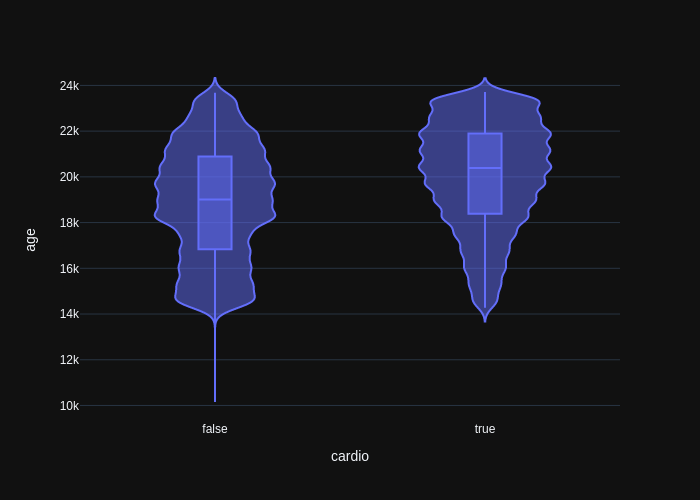

In [85]:
px.violin(df_eda, x='cardio', y='age', box=True)

Чем старше человек - тем выше риск заболеть.

### alco

In [14]:
print('Кол-во пациентов по признаку alco')
print(df_eda['active'].value_counts())

Кол-во пациентов по признаку alco
True     56261
False    13739
Name: active, dtype: int64


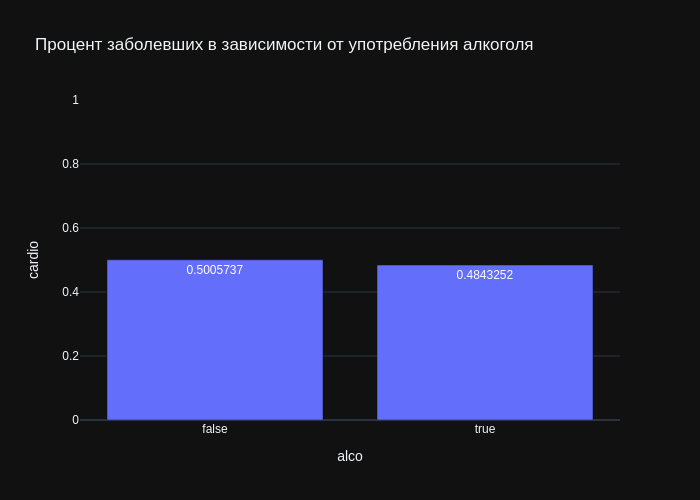

In [15]:
cardio_by_alco = df_eda.pivot_table(index='alco', values='cardio')

px.bar(
    cardio_by_alco,
    x=cardio_by_alco.index,
    y='cardio',
    title='Процент заболевших в зависимости от употребления алкоголя',
    text_auto=True,
    range_y=(0, 1),
)

### ap_hi

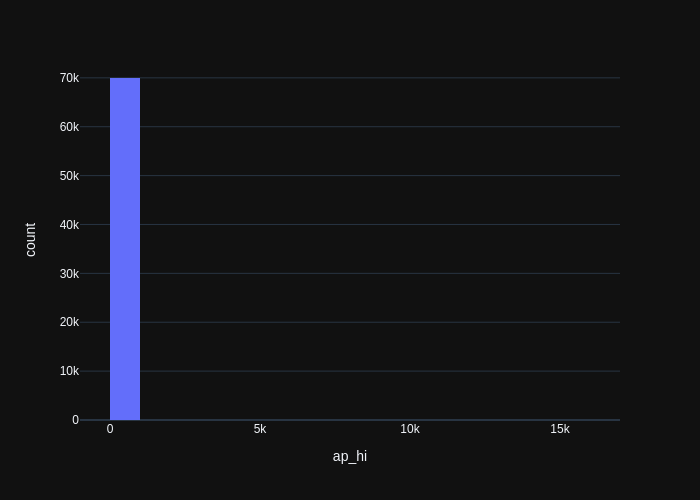

In [16]:
px.histogram(df_eda, x='ap_hi', nbins=20)

В данных явно есть выбросы. Отфильтруем

In [17]:
AP_HI__LOW = 80
AP_HI__HIGH = 220

df_ap_hi = make_pipeline(
    ml_utils.OutliersToNAN('ap_hi', AP_HI__LOW, AP_HI__HIGH),
    ml_utils.SimpleImputerMy('ap_hi'),
).fit_transform(df_eda)[['ap_hi', 'cardio']]

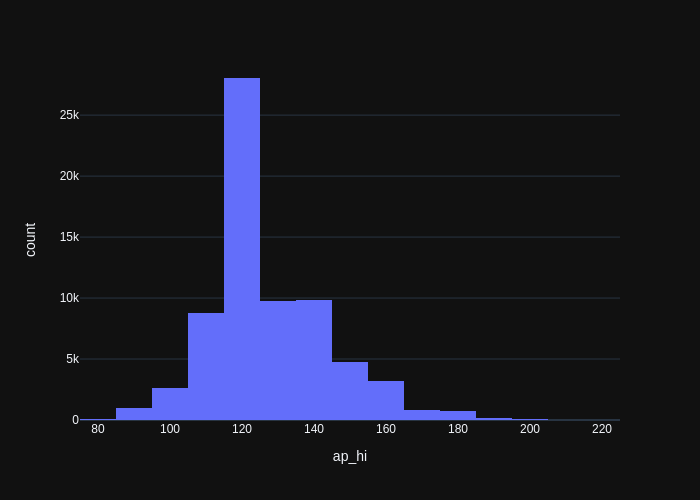

In [18]:
px.histogram(df_ap_hi, x='ap_hi', nbins=20)

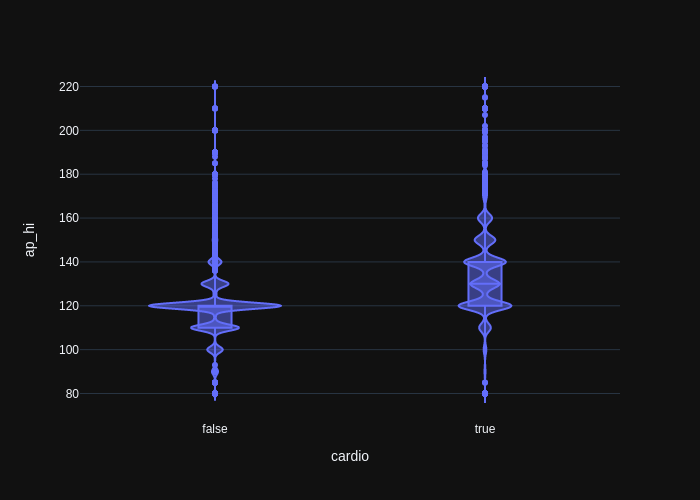

In [86]:
px.violin(df_ap_hi, x='cardio', y='ap_hi', box=True)

Чем выше давление - тем выше заболеваемость.

### ap_lo

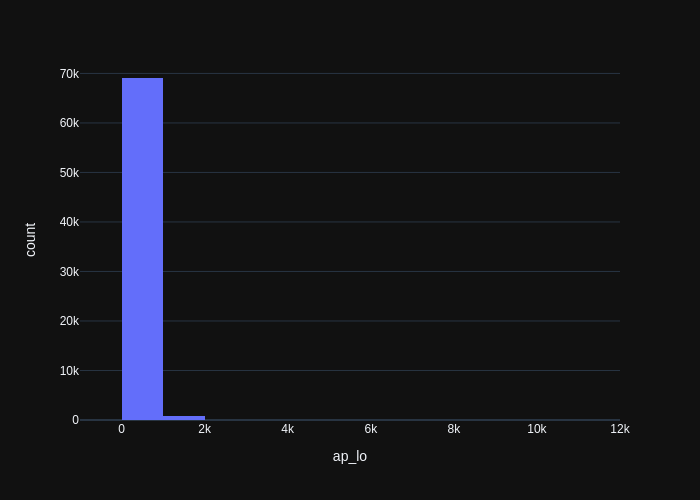

In [20]:
px.histogram(df_eda, x='ap_lo', nbins=20)

Аналогично верхнему давлению, здесь тоже есть выбросы.


In [21]:
AP_LO__LOW = 50
AP_LO__HIGH = 150

df_ap_lo = make_pipeline(
    ml_utils.OutliersToNAN('ap_lo', AP_LO__LOW, AP_LO__HIGH),
    ml_utils.SimpleImputerMy('ap_lo'),
).fit_transform(df_eda)[['ap_lo', 'cardio']]

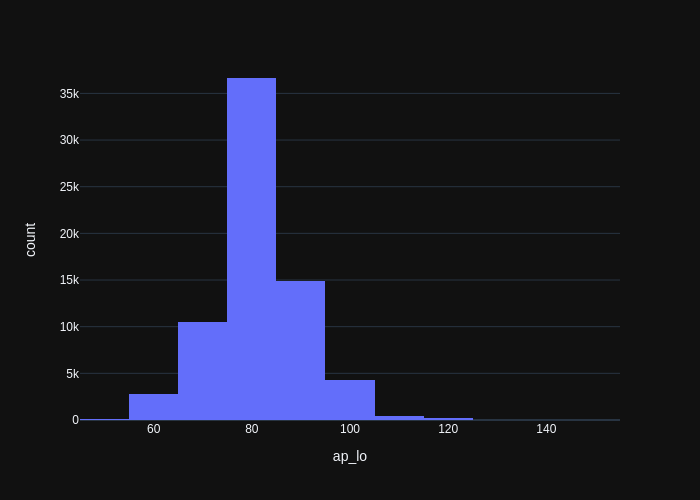

In [22]:
px.histogram(df_ap_lo, x='ap_lo', nbins=15)

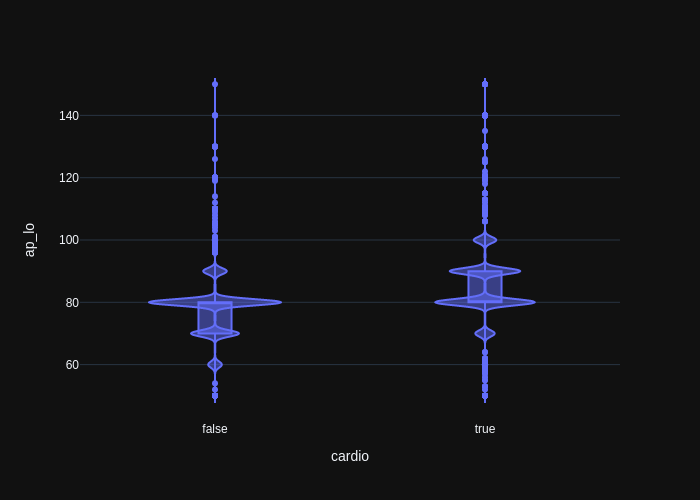

In [87]:
px.violin(df_ap_lo, x='cardio', y='ap_lo', box=True)

### cholesterol

In [24]:
print('Кол-во пациентов по признаку cholesterol')
print(df_eda['cholesterol'].value_counts())

Кол-во пациентов по признаку cholesterol
1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64


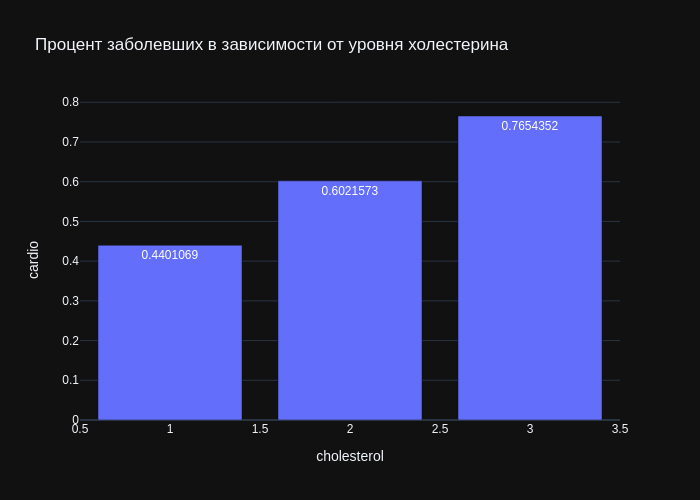

In [25]:
cardio_by_cholesterol = df_eda.pivot_table(
    index='cholesterol', values='cardio'
)

px.bar(
    cardio_by_cholesterol,
    x=cardio_by_cholesterol.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',
    text_auto=True
)

In [26]:
df_eda['id'].nunique()

70000

Все элементы в этой колонке уникальны. Признак бесполезен

In [27]:
def pre_id(df: pd.DataFrame) -> pd.DataFrame:
    """Clean id column."""
    return df.drop(columns=['id'])

### gender

In [28]:
print('Кол-во пациентов по признаку gender')
print(df_eda['gender'].value_counts())

Кол-во пациентов по признаку gender
1    45530
2    24470
Name: gender, dtype: int64


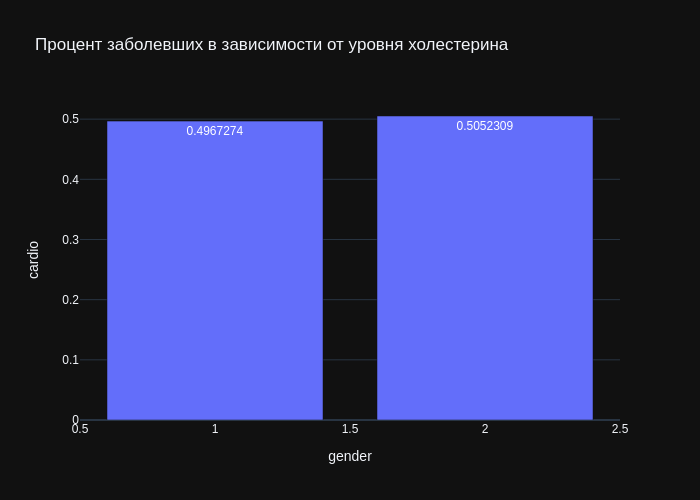

In [29]:
cardio_by_gender = df_eda.pivot_table(index='gender', values='cardio')

px.bar(
    cardio_by_gender,
    x=cardio_by_gender.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',
    text_auto=True
)

### gluc

In [30]:
print('Кол-во пациентов по признаку gluc')
print(df_eda['gluc'].value_counts())

Кол-во пациентов по признаку gluc
1    59479
3     5331
2     5190
Name: gluc, dtype: int64


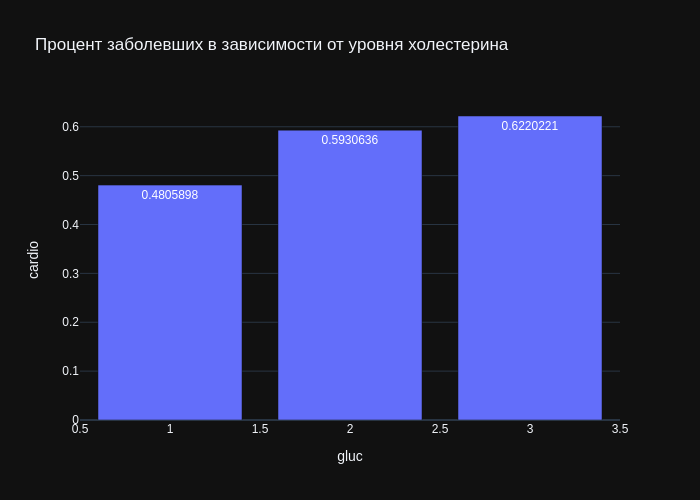

In [31]:
cardio_by_gluc = df_eda.pivot_table(index='gluc', values='cardio')

px.bar(
    cardio_by_gluc,
    x=cardio_by_gluc.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',  # TODO
    text_auto=True
)

### height

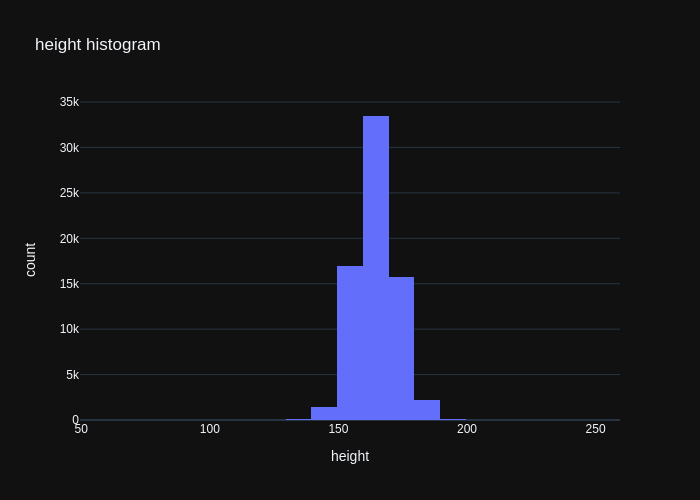

In [32]:
px.histogram(df_eda, x='height', nbins=25, title='height histogram')

In [33]:
HEIGHT__LOW = 140
HEIGHT__HIGH = 220

df_height = make_pipeline(
    ml_utils.OutliersToNAN('height', HEIGHT__LOW, HEIGHT__HIGH),
    ml_utils.SimpleImputerMy('height'),
).fit_transform(df_eda)

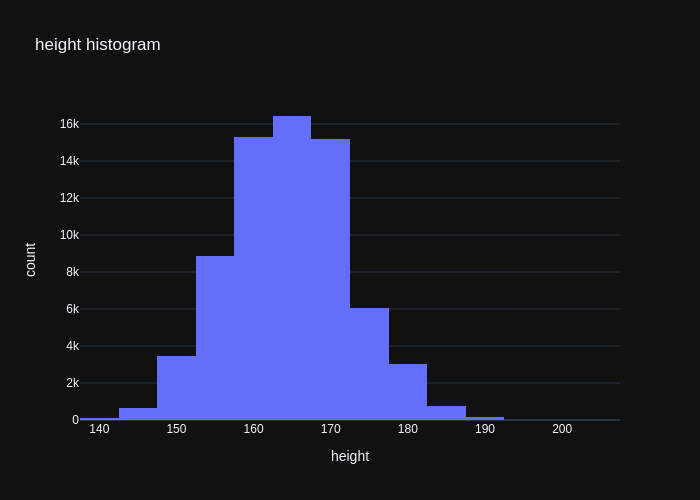

In [34]:
px.histogram(
    df_height, x='height', nbins=25, title='height histogram'
)

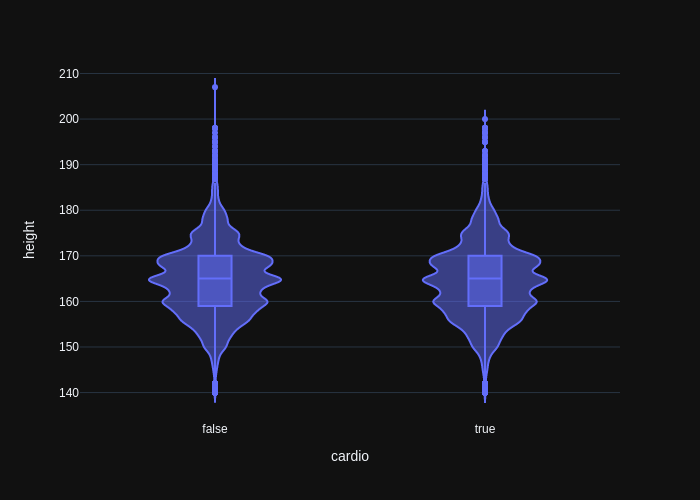

In [84]:
px.violin(df_height, x='cardio', y='height', box=True)

От роста заболеваемость не зависит.

### smoke

In [36]:
print('Кол-во курящих / некурящих пациентов')
print(df_eda['smoke'].value_counts())

Кол-во курящих / некурящих пациентов
False    63831
True      6169
Name: smoke, dtype: int64


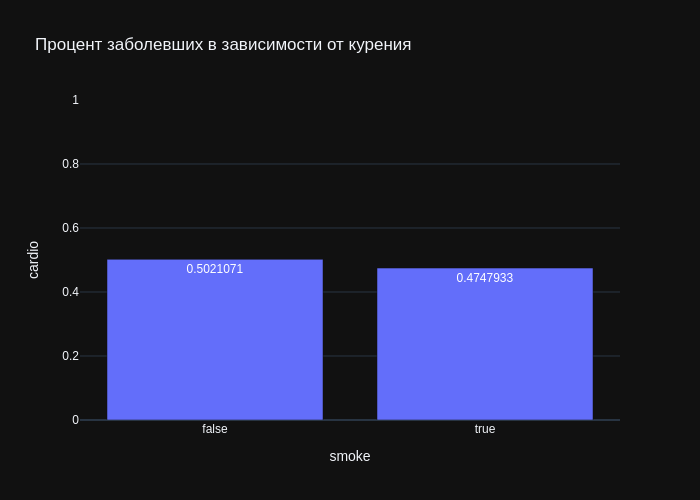

In [37]:
cardio_by_smoke = df_eda.pivot_table(index='smoke', values='cardio')

px.bar(
    cardio_by_smoke,
    x=cardio_by_smoke.index,
    y='cardio',
    title='Процент заболевших в зависимости от курения',
    text_auto=True,
    range_y=(0, 1),
)

### weight

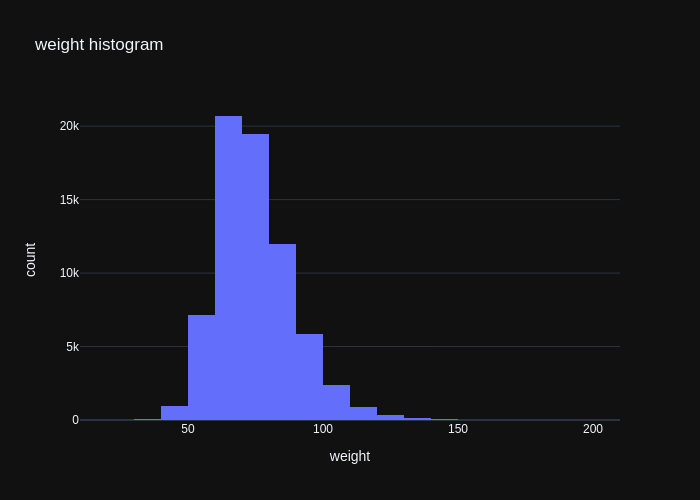

In [38]:
px.histogram(df_eda, x='weight', nbins=25, title='weight histogram')

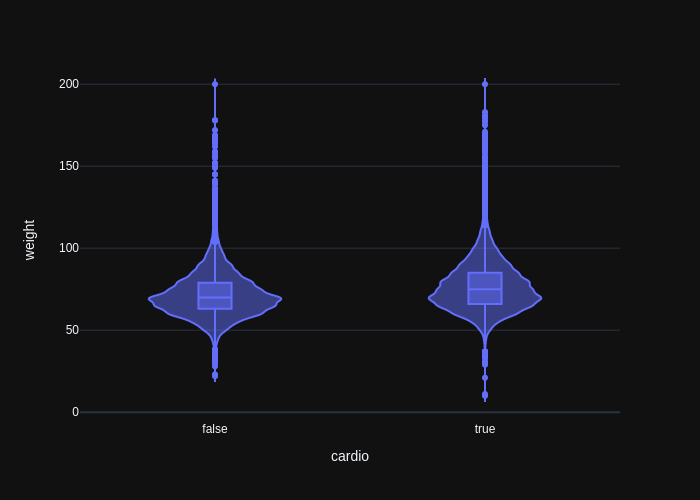

In [88]:
px.violin(df_eda, x='cardio', y='weight', box=True)

## Correlations

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003457,0.003502,-0.003038,-0.001830,0.003356,-0.002529,0.006106,0.002467,-0.003699,0.001210,0.003755,0.003799
age,0.003457,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,0.003502,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.003038,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486


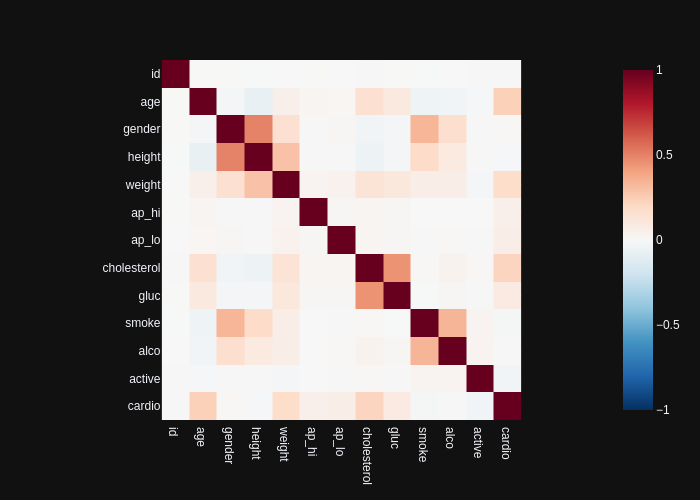

In [67]:
corr = df_eda.corr()

display(corr)

px.imshow(
    img=corr,
    # zmin=-1.0,
    color_continuous_scale='RdBu_r',
    range_color=(-1, 1)
)

### Mutual Information

In [41]:
feat = df_eda.drop(columns='cardio')
targ = df_eda['cardio']

mi_scores = pd.Series(
    data=mutual_info_classif(feat, targ),
    index=feat.columns,
)

print(mi_scores.sort_values(ascending=False))

ap_hi          0.115913
ap_lo          0.078576
age            0.031381
cholesterol    0.027735
weight         0.018130
gluc           0.010909
active         0.010324
gender         0.003153
id             0.000480
height         0.000121
smoke          0.000000
alco           0.000000
dtype: float64


### ap_lo vs ap_hi

Верхнее и нижнее давления хорошо коррелируют между собой

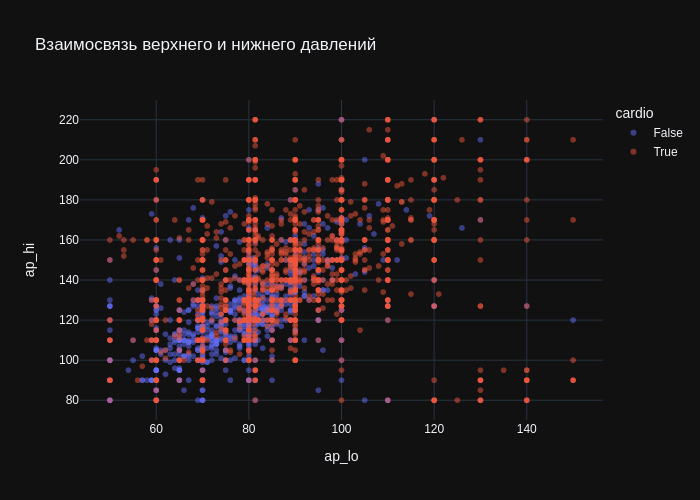

In [42]:
df_ap = df_ap_lo
df_ap['ap_hi'] = df_ap_hi['ap_hi']

px.scatter(
    df_ap,
    x='ap_lo',
    y='ap_hi',
    color='cardio',
    title='Взаимосвязь верхнего и нижнего давлений',
    opacity=0.5,
)

In [43]:
print('Коэффициент корреляции:')
print(df_ap['ap_lo'].corr(df_ap['ap_hi']))

Коэффициент корреляции:
0.6880125878218957


Можно заполнить неправильные значения, основываясь на значениях другого столбца

Значение верхнего давления должно быть больше нижнего. В датасете есть неправильные данные. Скорее всего, это ошибка ввода и значения можно поменять друг с другом.

In [44]:
print('Процент записей с неправильным порядком значений давления: ')
print((len(df[df['ap_hi'] < df['ap_lo']]) / len(df_eda) * 100))

Процент записей с неправильным порядком значений давления: 
1.7628571428571427


### height vs weight

/tmp/ipykernel_3086/2223766461.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



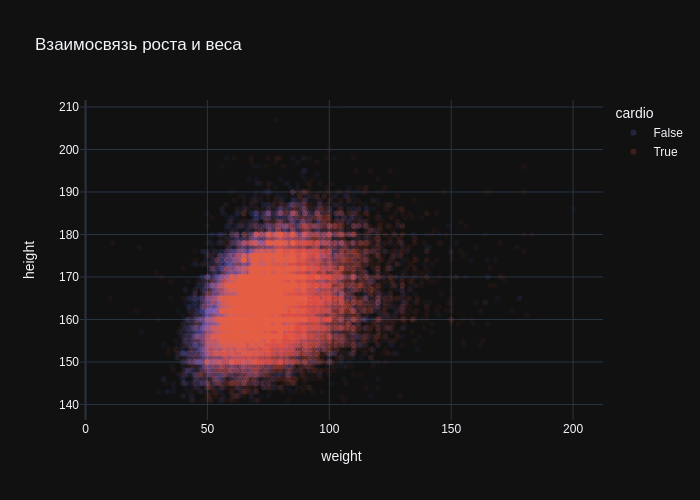

In [68]:
px.scatter(
    df_eda[(df['height'] < HEIGHT__HIGH) & (df['height'] > HEIGHT__LOW)],
    x='weight',
    y='height',
    color='cardio',
    title='Взаимосвязь роста и веса',
    opacity=0.05,
)

In [46]:
print('Коэффициент корреляции:')
print(df_eda['height'].corr(df_eda['weight']))

Коэффициент корреляции:
0.2909678349914985


Есть взаимосвязь роста и веса. Заполним неправильные значения роста на основе веса.

## Summary

Целевой признак в обучающей выборке сбалансирован.

В признаках ap_hi и ap_lo есть явно неправильные значения. Часть значений выходит за разумный диапазон; также ap_lo иногда больше ap_hi, чего не должно быть.

Есть неправильные значения в столбце height.

Признаки, от которых целевой признак зависит сильнее всего:
  - верхнее / нижнее давление (ap_hi, ap_lo)
  - возраст (age)
  - уровень холестерина (cholesterol)
  - вес (weight)

# Preprocess


Выделим признаки для обучения и целевой признак

In [90]:
FEATURES = ['active', 'age', 'alco', 'ap_hi', 'ap_lo', 'cholesterol', 'gender',
            'gluc', 'height', 'smoke', 'weight', ]
FEATURES_SCALE = ['age', 'ap_hi', 'ap_lo', 'height', 'weight', 'cholesterol',
                  'gluc', ]
FEATURES_ENCODE = ['gender', ]
TARGET = 'cardio'

df = load_train()

X = df[FEATURES]
y = df[TARGET]

Составим pipeline для предобработки

In [91]:
AP_HI__LOW = 60
AP_HI__HIGH = 240

AP_LO__LOW = 30
AP_LO__HIGH = 200

HEIGHT__LOW = 140
HEIGHT__HIGH = 210

pipe_preprocess = make_pipeline(
    # удалим экстремальные значения
    ml_utils.OutliersToNAN('ap_hi', AP_HI__LOW, AP_HI__HIGH),
    ml_utils.OutliersToNAN('ap_lo', AP_LO__LOW, AP_LO__HIGH),
    ml_utils.OutliersToNAN('height', HEIGHT__LOW, HEIGHT__HIGH),
    # верхнее давление должно быть больше нижнего
    ml_utils.SortInRow(['ap_hi', 'ap_lo'], ascending=False),
    # заполним пропуски давлений
    ml_utils.IterativeImputerPd(['ap_hi', 'ap_lo']),
    # заполним пропуски роста
    ml_utils.IterativeImputerPd(['height', 'weight']),
    # заполним все пропуски, если остались
    ml_utils.SimpleImputerMy(FEATURES),
    # кодирование категорий
    ml_utils.OneHotEncoderMy(FEATURES_ENCODE, drop='first'),
    # масштибирование
    ml_utils.StandardScalerMy(FEATURES_SCALE),
)

In [92]:
display(
    pipe_preprocess.fit_transform(X).head(10)
)

,active,age,alco,ap_hi,ap_lo,cholesterol,gluc,height,smoke,weight,gender_2.0
6670,1.0,-1.365848,0.0,0.758882,0.890974,-0.539322,-0.395720,-1.468279,0.0,1.305554,0
49567,1.0,-2.039476,0.0,-0.414929,-0.154131,-0.539322,-0.395720,-0.956007,0.0,1.027693,0
50796,1.0,0.150020,0.0,1.345788,0.890974,-0.539322,-0.395720,0.068537,0.0,-0.570012,0
22310,1.0,-0.575084,1.0,1.932693,1.936078,0.930735,1.351719,1.477286,1.0,0.958227,1
54037,0.0,-1.074023,0.0,0.758882,0.890974,-0.539322,-0.395720,0.068537,0.0,0.263573,1
6869,0.0,1.238283,0.0,0.758882,0.890974,-0.539322,-0.395720,2.373762,0.0,0.124642,1
13601,1.0,0.631531,0.0,1.932693,0.890974,-0.539322,-0.395720,-0.571803,0.0,-0.847873,0
3271,1.0,0.092060,0.0,-0.414929,-1.199236,-0.539322,-0.395720,0.580809,0.0,1.652882,0
12647,1.0,-0.372833,0.0,-0.414929,-0.154131,-0.539322,3.099157,-0.571803,0.0,-0.500546,0
13931,1.0,-1.136441,0.0,0.171977,0.890974,-0.539322,-0.395720,0.196605,0.0,-0.570012,0


# Models


В качестве метрики оптимизации выберем ROC AUC.

In [101]:
METRIC_FOR_OPTIM = 'roc_auc'

# модели для перерасчета
models_fit = {
    'dummy': False,
    'logreg': True,
    'svm': True,
    'rfc': True,
    'boost': True,
    'mlp': False,
}

## Dummy

In [154]:
model_dummy = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DummyClassifier(
            random_state=1,
        )),
    ],

)
params = {
    'model__strategy': ['most_frequent', 'prior', 'stratified', 'uniform']
}
cv_dummy = RandomizedSearchCV(
    estimator=model_dummy,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
if models_fit['dummy']:
    cv_dummy.fit(X, y)

    print(cv_dummy.best_score_)
    print(cv_dummy.best_params_)

## LogisticRegression

In [98]:
model_logreg = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LogisticRegression(
            n_jobs=-1,
            random_state=1,
            max_iter=100,
        )),
    ]
)
params = {
    'model__C': stats.uniform(0.1, 2.0),
}
cv_logreg = RandomizedSearchCV(
    estimator=model_logreg,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
if models_fit['logreg']:
    cv_logreg.fit(X, y)
    print(cv_logreg.best_score_)
    print(cv_logreg.best_params_)
    model_logreg = cv_logreg.best_estimator_
    print(
        'Метрики на обучающей выборке:',
        cross_val_score(model_logreg, X, y, scoring=METRIC_FOR_OPTIM)
    )

0.7930912410989397
{'model__C': 1.5406489868843163}
Метрики на обучающей выборке: [0.79420103 0.79454401 0.7951228  0.79026158 0.79132677]


## SVM

In [108]:
model_svm = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LinearSVC(
            random_state=1,
            max_iter=5000,
        )),
    ]
)
params = {
    'model__C': stats.uniform(0.1, 5.0),
}
cv_svm = RandomizedSearchCV(
    estimator=model_svm,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    n_iter=2,
)
if models_fit['svm']:
    cv_svm.fit(X, y)
    print(cv_svm.best_score_)
    print(cv_svm.best_params_)
    model_svm = cv_svm.best_estimator_
    print(
        'Метрики на обучающей выборке:',
        cross_val_score(model_svm, X, y, scoring=METRIC_FOR_OPTIM)
    )

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

L

Метрики на обучающей выборке: [0.79407797 0.79430606 0.79489305 0.79005816 0.7912473 ]


/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/sit

0.7929165063450866
{'model__C': 2.18511002351287}


/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

L

Метрики на обучающей выборке: [0.79407797 0.79430606 0.79489305 0.79005816 0.7912473 ]


## RandomForest

In [58]:
model_rfc = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', RandomForestClassifier(
            n_jobs=-1,
            random_state=1,
        )),
    ]
)
params = {
    'model__n_estimators': range(100, 500, 10),
    'model__max_depth': range(4, 20),
    'model__max_features': range(2, len(X.columns) + 1),
    'model__max_samples': stats.uniform(0.1, 0.9),
}
cv_rfc = RandomizedSearchCV(
    estimator=model_rfc,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    n_iter=10,
)

if models_fit['rfc']:
    cv_rfc.fit(X, y)
    print(cv_rfc.best_score_)
    print(cv_rfc.best_params_)
    model_rfc = cv_rfc.best_estimator_
    print(
        'Метрики на обучающей выборке:',
        cross_val_score(model_rfc, X, y, scoring=METRIC_FOR_OPTIM, n_jobs=-1)
    )

0.8022634280195803
{'model__max_depth': 13, 'model__max_features': 3, 'model__max_samples': 0.2263482447357104, 'model__n_estimators': 420}
Метрики на обучающей выборке: [0.79819144 0.80716418 0.80420877 0.80436251 0.79739024]


## HistGradientBoosting

In [94]:
model_boost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', HistGradientBoostingClassifier(
            random_state=1,
            max_iter=1000,
            early_stopping=True,
        )),
    ]
)
params = {
    'model__learning_rate': stats.uniform(0.01, 0.1),
    'model__max_depth': range(4, 10),
    'model__l2_regularization': stats.uniform(0, 20.0),
    'model__max_bins': range(150, 251, 5),
}
cv_boost = RandomizedSearchCV(
    estimator=model_boost,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    n_iter=10,
)
if models_fit['boost']:
    cv_boost.fit(X, y)
    print(cv_boost.best_score_)
    print(cv_boost.best_params_)
    model_boost = cv_boost.best_estimator_
    print(
        'Метрики на обучающей выборке:',
        cross_val_score(
            cv_boost.best_estimator_, X, y, scoring=METRIC_FOR_OPTIM, n_jobs=-1
        )
    )

0.803133903926156
{'model__l2_regularization': 17.892133270076947, 'model__learning_rate': 0.01850442113697779, 'model__max_bins': 215, 'model__max_depth': 7}
Метрики на обучающей выборке: [0.80471032 0.80379718 0.8054287  0.80048932 0.80124399]


## MLP

In [158]:
% % time

model_mlp = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('numpy', ml_utils.ToNumpyArray()),
        ('model', MLPClassifier(
            hidden_layer_sizes=(100, 80, 50),
            learning_rate='adaptive',
            random_state=1,
            activation='relu',
            max_iter=500,
            early_stopping=True,
            solver='lbfgs',
            verbose=True,
            alpha=0.1,
        )),
    ]
)
params = {
    # 'model__alpha': stats.uniform(1e-6, 1e-3),
    'model__alpha': [1],
}
cv_mlp = RandomizedSearchCV(
    estimator=model_mlp,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    cv=3,
    n_iter=1,
)
if models_fit['mlp']:
    model_mlp.fit(X, y)

    from sklearn.model_selection import cross_val_score

    model_mlp.set_params(**{'model__verbose': False})
    scores = cross_val_score(
        model_mlp, X, y, scoring=METRIC_FOR_OPTIM, n_jobs=-1
        )
    print(scores)
    print(scores.mean())

    # adam - 0.7377 59s
    # lbfgs - 0.751 9min 1000iter

    # cv_mlp.fit(X, y)
    # print(cv_mlp.best_score_)
    # print(cv_mlp.best_params_)
    # model_mlp = cv_mlp.best_estimator_
    # print(
    #     'Метрики на обучающей выборке:',
    #     cross_val_score(model_mlp, X, y, scoring=METRIC_FOR_OPTIM, n_jobs=-1)
    # )

CPU times: user 214 µs, sys: 0 ns, total: 214 µs
Wall time: 219 µs


## Stacking

In [111]:
model_stack = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', StackingClassifier(
            estimators=[
                ('rfc1', RandomForestClassifier(
                    random_state=1,
                    n_estimators=100,
                    max_depth=15,
                    n_jobs=-1,
                )),
                ('rfc2', RandomForestClassifier(
                    random_state=1,
                    n_estimators=100,
                    max_depth=10,
                    n_jobs=-1,
                )),
                ('boost', HistGradientBoostingClassifier(
                    random_state=1,
                    l2_regularization=10,
                    max_depth=7,
                    learning_rate=0.02,
                )),
                ('svm', LinearSVC(
                    random_state=1,
                ))
            ],
            final_estimator=LogisticRegression(
                random_state=1,
                n_jobs=-1,
            )
        )),
    ]
)
model_stack.fit(X, y)
print(
    'Метрики на обучающей выборке:',
    cross_val_score(
        model_stack, X, y, scoring=METRIC_FOR_OPTIM, n_jobs=-1,
    )
)
#
# params = {
#     'model__final_estimator__learning_rate': stats.uniform(0.001, 0.2),
#     'model__final_estimator__max_iter': [40000],
#     'model__final_estimator__max_depth': range(4, 10),
#     'model__final_estimator__l2_regularization': stats.uniform(0, 10.0),
# }
# cv_stack = RandomizedSearchCV(
#     estimator=model_stack,
#     param_distributions=params,
#     random_state=1,
#     n_jobs=-1,
#     scoring=METRIC_FOR_OPTIM,
#     cv=5,
#     n_iter=10,
# )
#
# if False:
#     cv_stack.fit(X, y)
#
#     print(cv_stack.best_score_)
#     print(cv_stack.best_params_)

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/inosat/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

L

Метрики на обучающей выборке: [0.80418559 0.80362741 0.80437435 0.79995189 0.80058257]


# Inspection


## Permutation importance

In [ ]:
result = permutation_importance(
    estimator=model_boost,
    X=X,
    y=y,
    n_repeats=5,
    random_state=1,
    n_jobs=-1,
)
display(
    ml_utils.display_permutation_importance(
        result=result,
        x_columns=X.columns,
    )
)

## Shap


Permutation explainer: 501it [01:49,  4.18it/s]                         


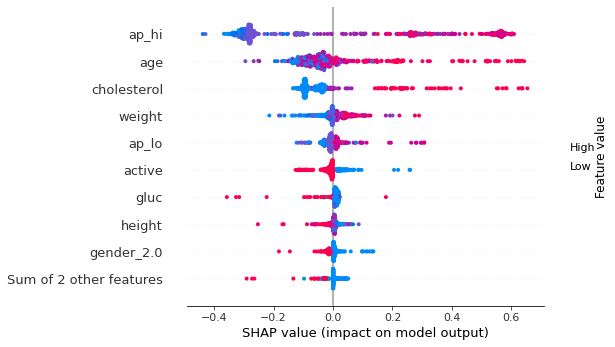

In [95]:
mode_for_shap = model_boost

X_shap = mode_for_shap[:-1].transform(X).sample(n=500, random_state=1)

shap_explainer = shap.Explainer(
    model=mode_for_shap[-1].predict,
    masker=X_shap,
)
shap_values = shap_explainer(X_shap)

shap.plots.beeswarm(shap_values)

Определим для примера двух новых пациентов, и посмотрим, как shap объясняет, почему пациент может быть болен или нет.

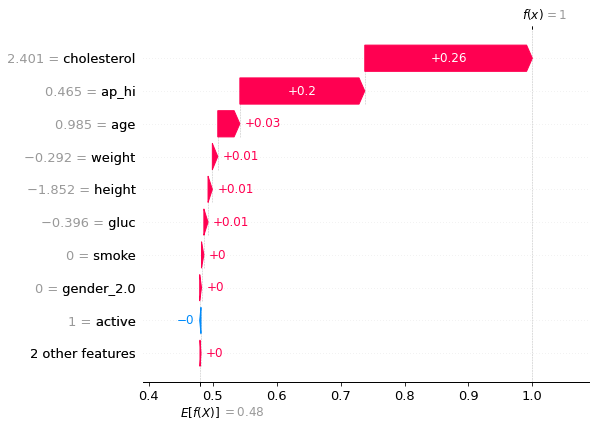

In [96]:
patient_with_cardio = {
    'active': 1,
    'age': 60 * 365,
    'alco': 0,
    'ap_hi': 135,
    'ap_lo': 80,
    'cholesterol': 3,
    'gender': 1,
    'gluc': 1,
    'height': 150,
    'smoke': 0,
    'weight': 70,
}
patient_with_cardio = mode_for_shap[:-1].transform(
    pd.DataFrame([patient_with_cardio])
)
shap.plots.waterfall(shap_explainer(patient_with_cardio)[0])

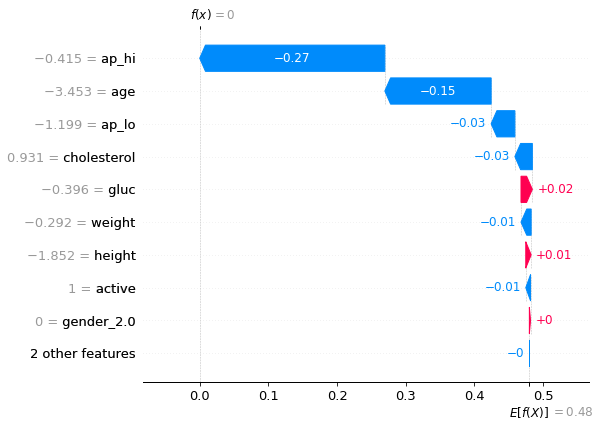

In [97]:
patient_without_cardio = {
    'active': 1,
    'age': 30 * 365,
    'alco': 0,
    'ap_hi': 120,
    'ap_lo': 70,
    'cholesterol': 2,
    'gender': 1,
    'gluc': 1,
    'height': 150,
    'smoke': 0,
    'weight': 70,
}
patient_without_cardio = mode_for_shap[:-1].transform(
    pd.DataFrame([patient_without_cardio])
)
shap.plots.waterfall(shap_explainer(patient_without_cardio)[0])

# Submission

In [ ]:
model_for_submit = model_mlp

df_subm = load_test()

submission = pd.DataFrame(
    data=model_for_submit.predict(df_subm[FEATURES]),
    index=df_subm['id'],
    columns=[TARGET],
)
submission['cardio'] = submission['cardio'].astype(float)
submission.to_csv('../data/my_submission.csv')
